# Lane Detection and Tacking - Polynomial Curve Fit

## 1. Imports and global vars

### 1.1. Import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import re

### 1.2. Global variables

In [2]:
is_debug = False
bad_frame_flag = True
write_to_file = False
frame_counter = {k: 0 for k in ['all', 'bad']}

### 1.3. Utilities and helper functions

The implementation resides in [tools/utils.py](tools/utils.py): *BaseUtils* and *VidProc* classes

*Utils* main functions:
- plot images

*VidProc* main functions:
- display video
- write video to file
- resize video
- get frame from video

In [3]:
from tools.utils import BaseUtils as Utils
Utils.write_to_file = write_to_file # init static flag write_to_file

from tools.utils import VidProc
VidProc.write_to_file = write_to_file  # init static flag write_to_file

### 1.4. Image processing tools

Class *ImgProc* extends the functionality of [tools/image_processing.py](tools/image_processing.py): *BaseImgProc* class

Main functions:
- Thresholds: relative and absolute
- Edge detection: Canny, Laplace, Sobel X/Y
- Image smoothing: Gaussian Blur
- Convert image color to grayscale
- Image thresholding
- Normalization


In [4]:
from tools.image_processing import BaseImgProc

class ImgProc(BaseImgProc):

    @classmethod
    def canny_pipeline(cls, img, threshold_low=100, threshold_high=200, ksize=(5, 5), color=cv2.COLOR_BGR2GRAY):
        """ 
        Applies Canny edge detection pipeline which includes:
        1. Grayscale image conversion
        2. Gaussian Blur
        3. Cannny edge detection
        :param img: input image
        :param threshold_low: low threshold for hysteresis procedure
        :param threshold_high: high threshold for hysteresis procedure
        :param ksize: Gaussian kernel size. Tuple of two odd integers. E.g. (5, 5)
        :param color_space: the color space conversion code (default: cv2.COLOR_BGR2GRAY)
        """
        img_gray = ImgProc.convert_color(img, color)
        img_blur = cls.gaussian_blur(img_gray, ksize)
        edges = cls.canny(img_blur, threshold_low=threshold_low, threshold_high=threshold_high)
        return edges
    
    @classmethod
    def threshold_rel(cls, img, lo, hi):
        """
        The function applies a relative threshold to the image single channel
        :param img: input image
        :param lo: low threshold
        :param hi: high threshold
        Returns: 
        Returns a binary image where the pixel values are set to 255 if they fall within the range [vlo, vhi], and 0 otherwise
        """
        vmin = np.min(img)  # min pixel value
        vmax = np.max(img)  # max pixel value
        
        vlo = vmin + (vmax - vmin) * lo  # min threshold value
        vhi = vmin + (vmax - vmin) * hi  # max threshold value
        return np.uint8((img >= vlo) & (img <= vhi)) * 255

    @classmethod
    def threshold_abs(cls, img, lo, hi):
        """
        This function applies an absolute threshold to an image
        :param img: input image
        :param lo: absolute low threshold
        :param hi: absolute high threshold
        Returns:
            Returns a binary image where the pixel values are set to 255 if they fall within the range [lo, hi], and 0 otherwise.
        """
        return np.uint8((img >= lo) & (img <= hi)) * 255

## 2 Load Video

### 2.1 Extract frames
We extract frames so it will be easier to test thresholds and work on problematic frames, it can be more convinient when eperimenting thresholds

In [5]:
# video file location
input_video_day = 'videos/in/daylight_video_1280x720.mp4'

# load video
day_vclip_1 = VideoFileClip(input_video_day)

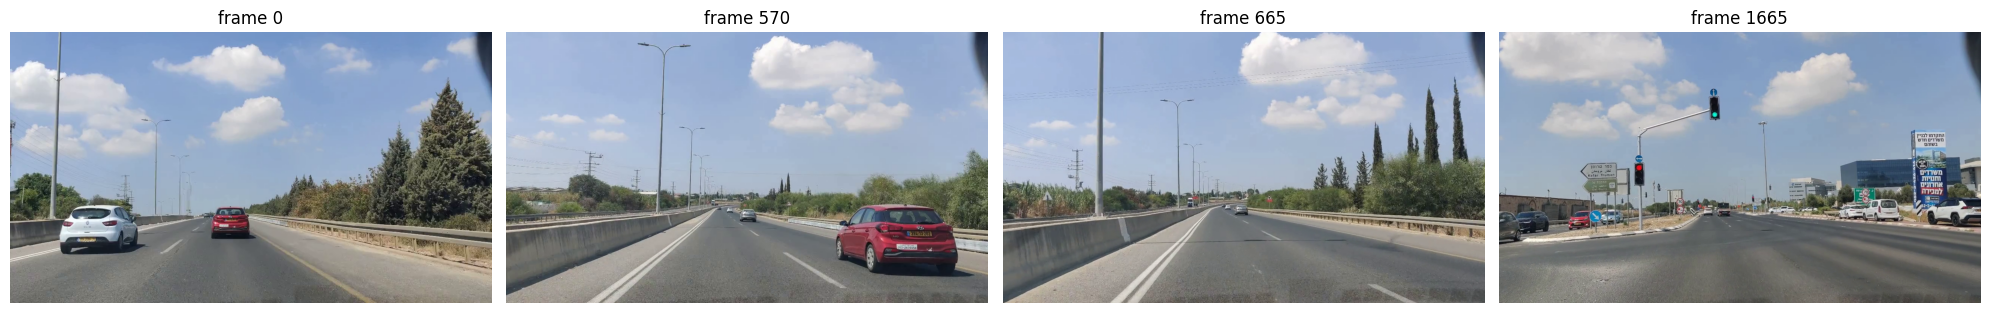

In [6]:
images = []
for frame_indx in [0, 570, 665, 1665]:
    v_frame = VidProc.get_clip_frame(day_vclip_1, frame_indx)
    # images.append(v_frame)
    images.append({'img': v_frame, 'title': f"frame {frame_indx}"})


Utils.plot_images(*images,  width=5, height=3.5, axis='off')

## 3 Perspective Transform
We apply perspective transform on the rigion of interest (ROI) to have birdeye perspective.
As you will see, it simplifies the processing.

### 3.1 Figure the birdeye perspective
To make our work easier, we chage a repgion of the image to a birdeye point of view (BEV) by using a linear transformation. 

In [7]:
class PerspectiveTransformation:
    """ This a class for transforming image between front view and top view

    Attributes:
        src (np.array): Coordinates of 4 source points
        dst (np.array): Coordinates of 4 destination points
        M (np.array): Matrix to transform image from front view to top view
        M_inv (np.array): Matrix to transform image from top view to front view
    """
    def __init__(self, src_points, dst_points):
        """
        Init PerspectiveTransformation
        """
        self.src = np.array(src_points, dtype=np.float32)
        self.dst = np.array(dst_points, dtype=np.float32)
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)

    def forward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a front view image and transform to top view

        Parameters:
            img (np.array): A front view image
            img_size (tuple): Size of the image (width, height)
            flags : flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Top view image
        """
        return cv2.warpPerspective(img, self.M, img_size, flags=flags)

    def backward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a top view image and transform it to front view

        Parameters:
            img (np.array): A top view image
            img_size (tuple): Size of the image (width, height)
            flags (int): flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Front view image
        """
        return cv2.warpPerspective(img, self.M_inv, img_size, flags=flags)


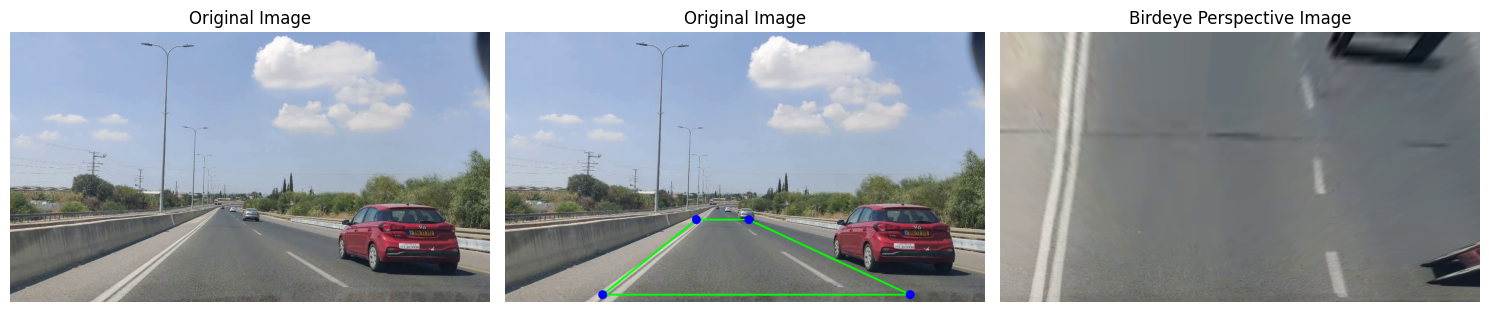

In [8]:
top_y = 500
bottom_y = 700
top_left, top_right = (510, top_y), (650, top_y)
bottom_left, bottom_right = (260, bottom_y), (1080, bottom_y)

src_points = [top_left, bottom_left, bottom_right, top_right]
dst_points = [(100, 0), (100, 720), (1100, 720), (1100, 0)]

img_1 = images[1]['img']
img_roi = img_1.copy()
cv2.polylines(img_roi, np.array([src_points], np.int32), isClosed=True, color=(0, 255, 0), thickness=3)
for p in src_points:
    cv2.circle(img_roi, p, 12, (0, 0, 255), -1)

pers =  PerspectiveTransformation(src_points, dst_points)
top_view = pers.forward(img_1)

Utils.plot_images({'img': img_1, 'title': 'Original Image'}, {'img': img_roi, 'title': 'Original Image'}, {'img': top_view, 'title': 'Birdeye Perspective Image'}, width=5, height=3.5, axis='off',save_fig="images/doc/a2/roi_birdeye_list.png")

## 4  Experiment frames

#### 4.1 Experiment with color map
- Convert RGB to HLS/HSV
- Examine the difference when applying HLS/HSV on different channels in colored image (3-channels)


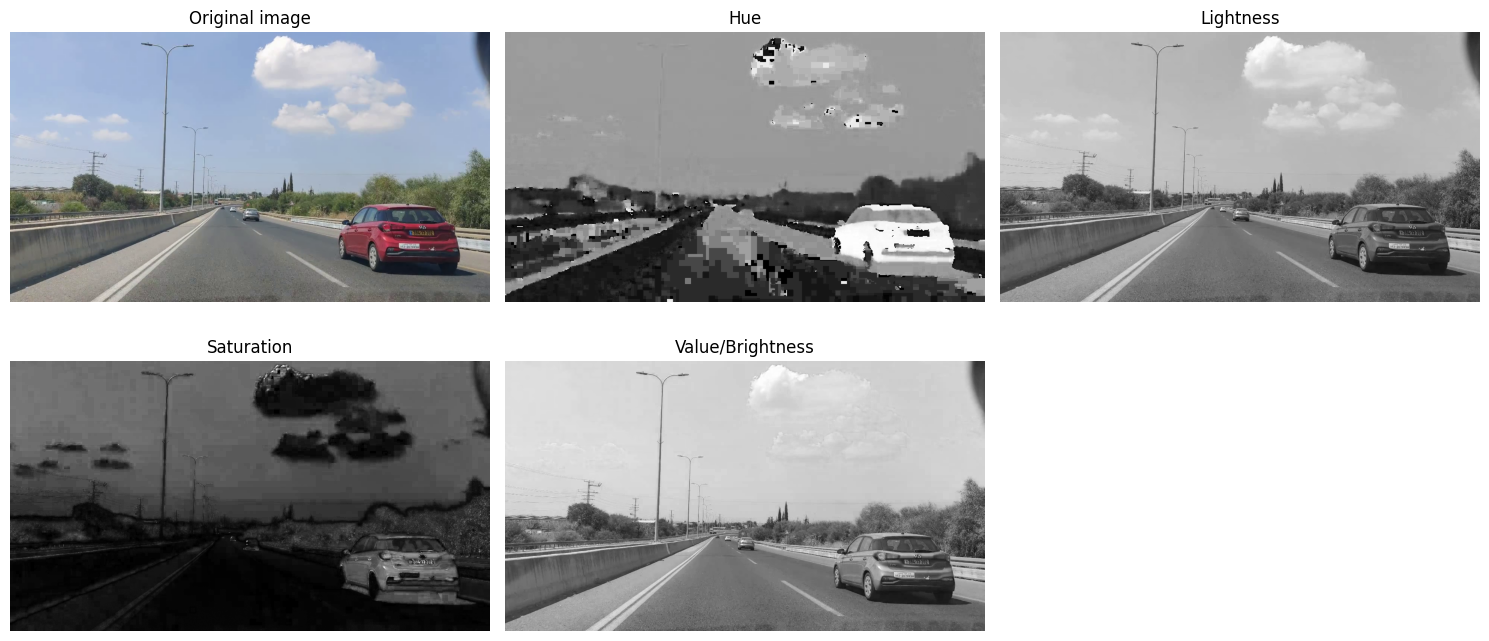

In [9]:
# Examine how HLS & HSV Colorization scheme works.

# use the 1st image (for example)
cm_images = []
img_cp = images[1]['img'].copy()
hls_img, hsv_img = ImgProc.convert_color(img_cp, cv2.COLOR_RGB2HLS),ImgProc.convert_color(img_cp, cv2.COLOR_RGB2HSV)
cm_images = [
    {'img':img_cp, 'title': 'Original image'},
    {'img': hls_img[:, :, 0], 'title': 'Hue', 'cmap': 'gray'},
    {'img': hls_img[:, :, 1], 'title': 'Lightness', 'cmap': 'gray'},
    {'img': hls_img[:, :, 2], 'title': 'Saturation', 'cmap': 'gray'},
    {'img': hsv_img[:, :, 2], 'title': 'Value/Brightness', 'cmap': 'gray'},
]

Utils.plot_images(*cm_images,  width=5, height=3.5, n_cols=3, axis='off', save_fig="images/doc/a2/cmap_image_list.png")

#### 4.2 Test Thresholds
Test different threshold values to see how they interact with the channel so we could examine the extraction of the lane lines

In [10]:
def test_thresh(img, is_debug=False):
    
    tmp = np.copy(img)
    hls = ImgProc.convert_color(tmp, cv2.COLOR_RGB2HLS)
    hsv = ImgProc.convert_color(tmp, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
    
    # Light
    light_img = ImgProc.threshold_rel(l_channel, 0.8, 1.0)
    
    # Saturation
    saturation_img = ImgProc.threshold_rel(s_channel, 0.5, 0.8)
    
    # Hue&Value
    hue_and_value = ImgProc.threshold_abs(h_channel, 20, 30)
    hue_and_value &= ImgProc.threshold_rel(v_channel, 0.60, 1.0) 

    # Hue Only
    hue_only =  ImgProc.threshold_abs(h_channel, 20, 30)

    # Value/Bright only
    bright_img = ImgProc.threshold_rel(v_channel, 0.60, 1.0)

    gray =  ImgProc.convert_color(img, cv2.COLOR_RGB2GRAY)

    # Normalized Image
    normalized = ImgProc.normalize(gray, alpha=170, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_thresh = ImgProc.threshold_rel(normalized, 0.60, 1.0)

    if is_debug:
        threshold_images = [
            {'img':tmp, 'title': 'Original image'},
            {'img': light_img, 'title': 'Light', 'cmap': 'gray'},
            {'img': saturation_img, 'title': 'Saturation', 'cmap': 'gray'},
            {'img': hue_and_value, 'title': 'Hue&Value', 'cmap': 'gray'},
            {'img': hue_only, 'title': 'Hue Only', 'cmap': 'gray'},
            {'img': bright_img, 'title': 'Value/Bright only', 'cmap': 'gray'},
            {'img': gray, 'title': 'Gray Image', 'cmap': 'gray'},
            {'img': normalized_thresh, 'title': 'Normalized Image', 'cmap': 'gray'}
        ]

        Utils.plot_images(*threshold_images,  width=5, height=3.5, n_cols=3, axis='off', save_fig="images/doc/a2/filtered_image_list.png")

    return normalized_thresh
    

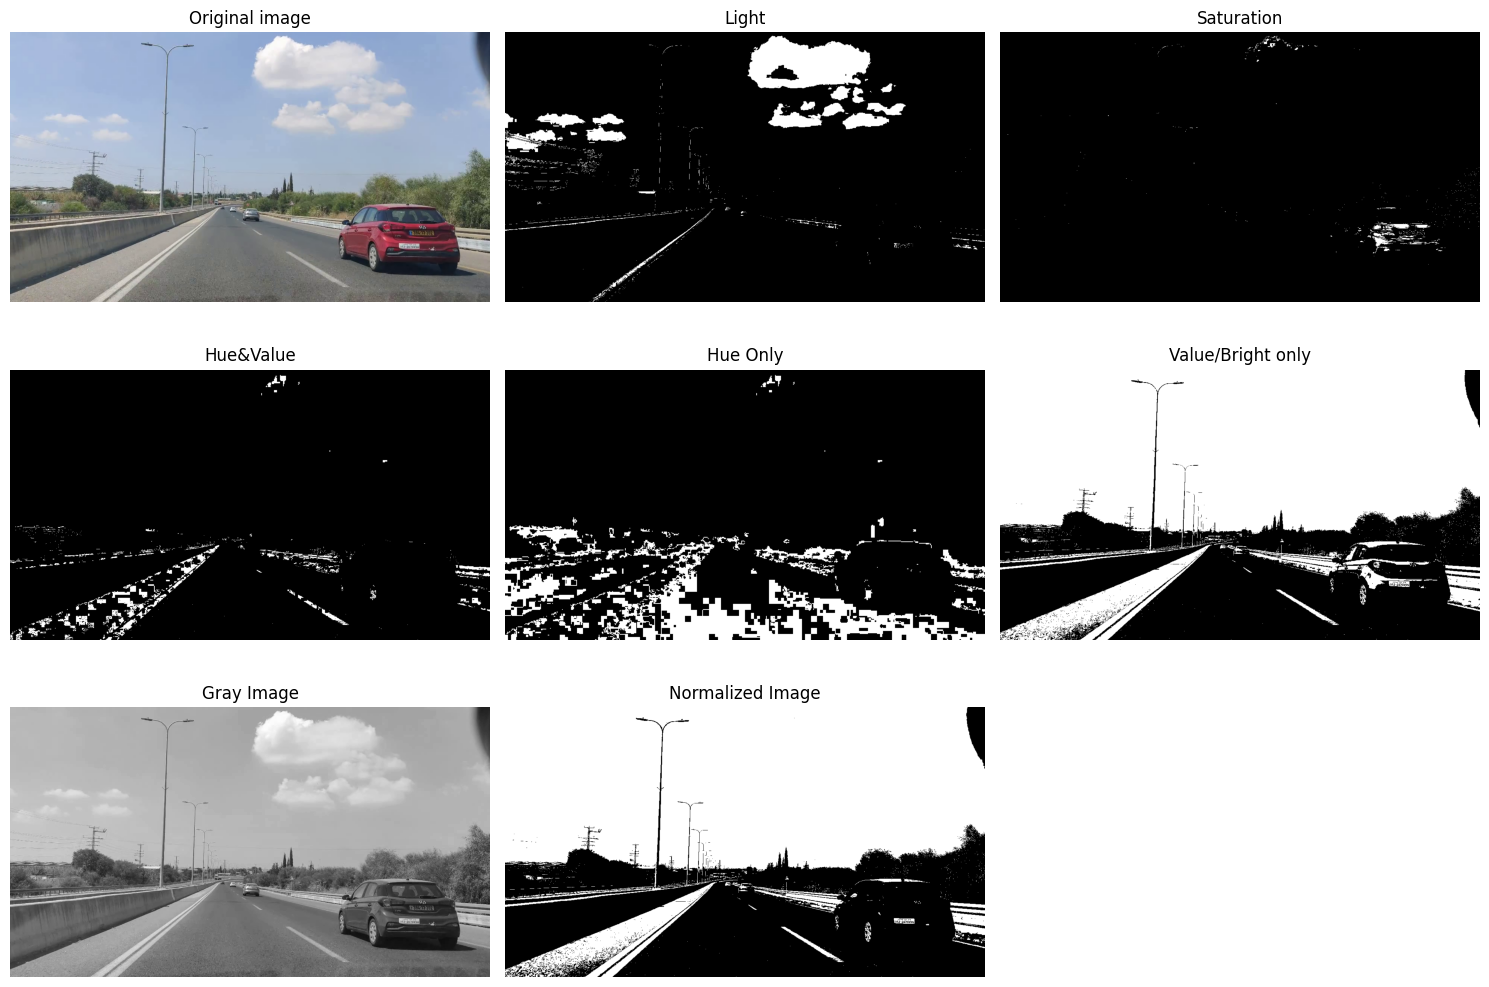

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [11]:
test_thresh(img_1, is_debug=True)

### 4.3 Apply various thresholds on BEV image


In [12]:
def filter_lanes(img, is_debug=False, is_rgb=False):
    """
    :param img: image in top view - bird eye view
    """
    #when in right lane
    if is_rgb:
        hls = ImgProc.convert_color(img, cv2.COLOR_RGB2HLS)
        hsv = ImgProc.convert_color(img, cv2.COLOR_RGB2HSV)
        gray = ImgProc.convert_color(img, cv2.COLOR_RGB2GRAY)
    else:
        #open cv uses BGR
        hls = ImgProc.convert_color(img, cv2.COLOR_BGR2HLS)
        hsv = ImgProc.convert_color(img, cv2.COLOR_BGR2HSV)
        gray = ImgProc.convert_color(img, cv2.COLOR_BGR2GRAY)

    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]

    right_lane = ImgProc.threshold_rel(l_channel, 0.65, 0.72)
    right_lane[:,:750] = 0
    
    left_lane = ImgProc.threshold_abs(h_channel, 20, 40)
    left_lane &= ImgProc.threshold_rel(v_channel, 0.69, 1.0)
    left_lane[:,550:] = 0

    binary_lane_mask = left_lane | right_lane
    
    canny_edges_only = ImgProc.canny_pipeline(img, threshold_low=10, threshold_high=80, ksize=(5, 5))

    # Apply dilation
    dilated_image = ImgProc.dilate(canny_edges_only, ksize=(5, 5), iterations=1)
    canny_combined = binary_lane_mask  | canny_edges_only

    #Normalized image
    normalized = ImgProc.normalize(gray, alpha=170, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_thresh = ImgProc.threshold_rel(normalized, 0.62, 1.0)

    if is_debug:
        filtered_images = [
            {'img':img, 'title': 'Original image'},
            {'img': right_lane, 'title': 'Light', 'cmap': 'gray'},
            {'img': left_lane, 'title': 'Heu & Saturation', 'cmap': 'gray'},
            {'img': binary_lane_mask, 'title': 'Heu & Light(Combined)', 'cmap': 'gray'},
            {'img': canny_edges_only, 'title': 'Canny', 'cmap': 'gray'},
            {'img': canny_combined, 'title': 'Canny + Combined', 'cmap': 'gray'},
            {'img': dilated_image, 'title': 'Dialated Canny', 'cmap': 'gray'},
            {'img': normalized_thresh, 'title': 'Normalized Image', 'cmap': 'gray'}
        ]

        Utils.plot_images(*filtered_images,  width=5, height=3.5, n_cols=3, axis='off', save_fig="images/doc/a2/filtered_image_list.png")
    
    return normalized_thresh
        

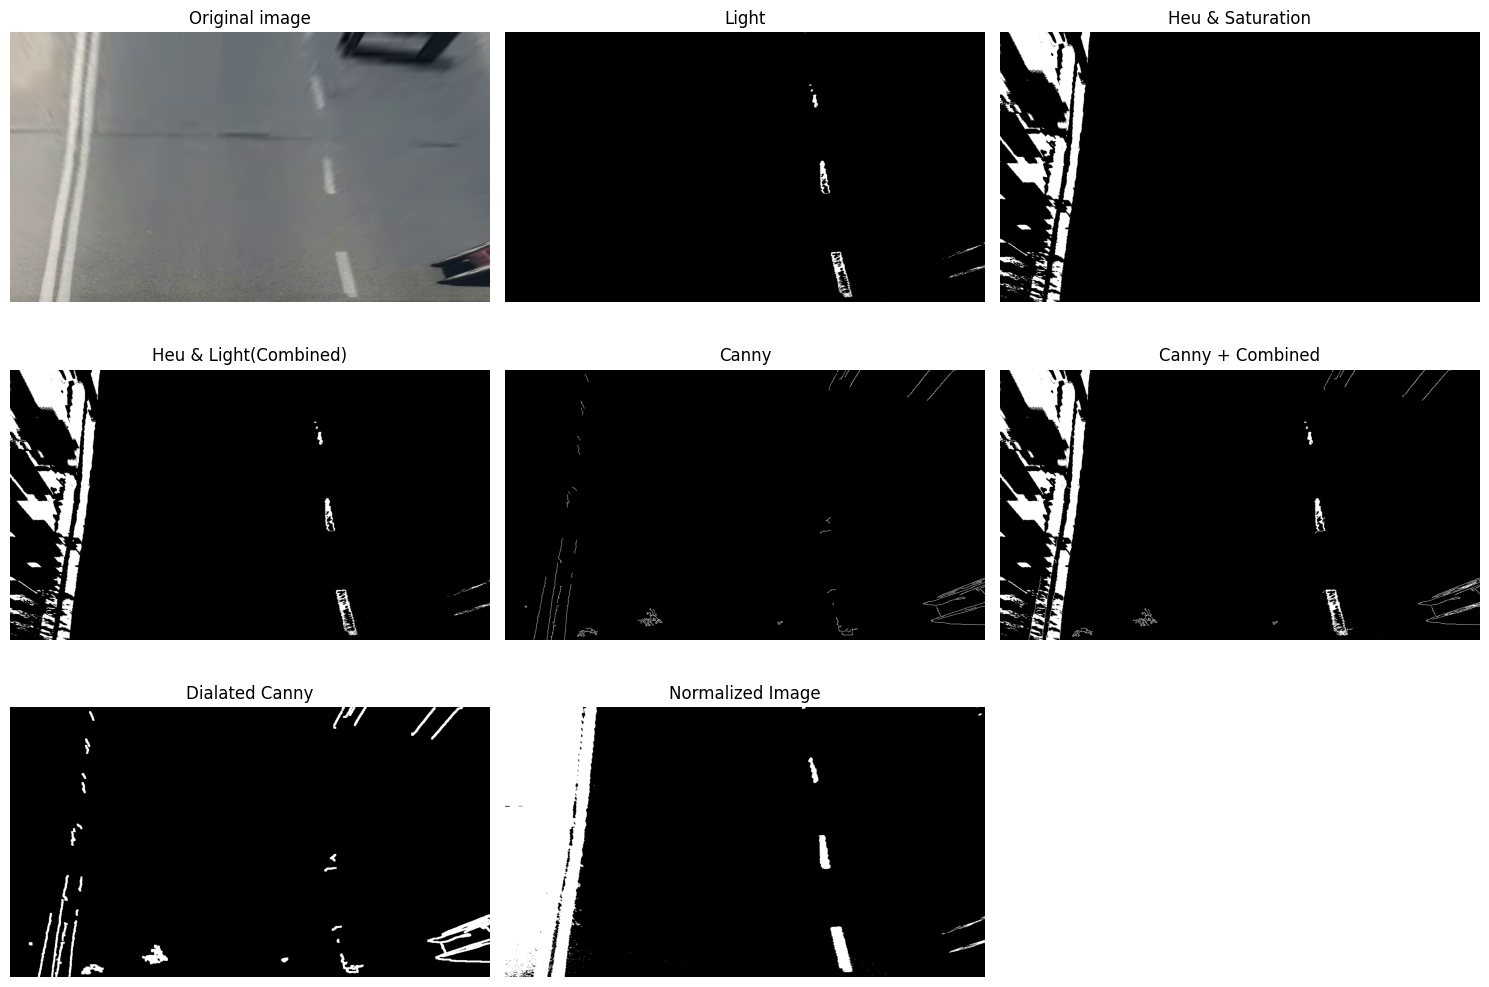

In [13]:
img2 = top_view.copy()
filtered_lane1 =  filter_lanes(img2, is_debug=True,is_rgb=True)

Here we see that Heu & Light(Combined) gives a good lane lines as well as Normalized Image. We will test them farther later

## 5 Lane Detection Pipeline

### 5.1 Pipeline Overview

* Transform region of interest using affinis transformation
    - Select ROI (region of interest)
    - Create BEV using perspective transform from the ROI image
* Convert image to grayscale (1-channel)
* Create binary mask by applying threshold function in order to highlight the lane line pixels
<!--* Histogram to find the lanes - it summerizes all the vertical information into an horizontal array -->
<!--* Retrieve non-zero pixels by walking through the histogram output -->
* Fit 2nd deegree polynom to the lane left and right lines
    - Create image histogram by summarizing all the vertical information into the horizontal array (section 5.2)
    - find the expected x loctions of the right and left lanes
    - initialize window height so we will be at the first windown at height of image height - half window height
    - Retrieve non-zero pixels by walking through the different patchs (section 5.3) around an area of expected lane for each expected lane at side 
    - Apply threshold of minimum good pixels in the area of left and right lines


* Fit curve to polynomial equiation:
    - Go over all the non-zero pixels Walk through the pixels Goes over all the pixels that are non-zero in each window
* fitting 2nd degreee polynom for right side and left side
* in case of fail to fit any of the sides - return a default shape in different color

### 5.2 Histogram
to find the lanes - it summerizes all the vertical information into an horizontal array

In [14]:
def hist(img):
    """
    Utility function for extracting a histogram
    """
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

### 5.3 non-zero pixels in a window
return all the indexes of non-zero pixels withing a given window

In [15]:
def pixels_in_window(img,center, margin, height):
    """ Return all pixel that in a specific window

    Parameters:
        img (image): the color image
        center (tuple): coordinate of the center of the window
        margin (int): half width of the window
        height (int): height of the window

    Returns:
        pixelx (np.array): x coordinates of pixels that lie inside the window
        pixely (np.array): y coordinates of pixels that lie inside the window
    """
    # Identify the x and y positions of all nonzero pixel in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    topleft = (center[0]-margin, center[1]-height//2)
    bottomright = (center[0]+margin, center[1]+height//2)

    condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
    condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
    return nonzerox[condx&condy], nonzeroy[condx&condy]

### 5.4 Find Lane Lines
Process the binary image as follows:
* Create image histogram by summarizing all the vertical information into the horizontal array (section 5.2)
* Find the expected x loctions of the right and left lanes
* Initialize window height so we will be at the first windown at height of image height - half window height
* Retrieve non-zero pixels by walking through the different patchs (section 5.3) around an area of expected lane for each expected lane at side 
* Apply threshold of minimum good pixels (minpix) in the area of left and right lines

In [16]:
def find_lane_pixels(bin_image,num_windows=9, is_debug=False):
    """
    return lists of idexes of left lane and right lane
    """
   
    out_img = np.zeros((bin_image.shape[0], bin_image.shape[1], 3), dtype=np.uint8)
    histogram = hist(bin_image) #create a map of columns of the binary image -of the bottom half, the higher the value the more white pixels in the column - lane
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint]) #find the column with the most white pixels in the left half of the image
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint #find the column with the most white pixels in the right half of the image

    center_points = [] # for debug

    # Current position to be update later for each window in num_windows
    leftx_current = leftx_base
    rightx_current = rightx_base
    window_height = np.int32(bin_image.shape[0]//num_windows)
    margin = 100
    # margin = 50
    y_current = bin_image.shape[0] + window_height//2

    # Create empty lists to reveice left and right lane pixel
    leftx, lefty, rightx, righty = [], [], [], []
    # Step through the windows one by one from top to bottom
    for _ in range(num_windows):
        y_current -= window_height
        center_left = (leftx_current, y_current)
        center_right = (rightx_current, y_current)

        good_left_x, good_left_y = pixels_in_window(bin_image,center_left, margin, window_height)
        good_right_x, good_right_y = pixels_in_window(bin_image,center_right, margin, window_height)

        # Append these indices to the lists
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)
        rightx.extend(good_right_x)
        righty.extend(good_right_y)

        minpix = 50
        if len(good_left_x) > minpix:
                leftx_current = np.int32(np.mean(good_left_x))
        if len(good_right_x) > minpix:
                rightx_current = np.int32(np.mean(good_right_x))
        center_points.append((center_left,center_right))

    if is_debug:
        f = plt.figure(figsize=(24, 16))
        ax1 = f.add_subplot(3, 1, 1)
        ax1.imshow(bin_image,vmin=0, vmax=255, cmap='gray')
        ax1.set_title('Binary image')
        binary_image2 = np.dstack((bin_image,bin_image,bin_image))
        ax2 = f.add_subplot(3, 1, 2)
        midpoint = histogram.shape[0] // 2
 
        histogram_normalized = histogram // 255
        ax2.plot(range(binary_image2.shape[1]),histogram_normalized)
        
        
        ax2.set_title('Histogram')
        
        binary_image3 = np.dstack((bin_image,bin_image,bin_image))

        for el in center_points:
            cur_left_center = el[0]
            cur_right_center = el[1]
            height = window_height
            topleft_l = (cur_left_center[0]-margin, cur_left_center[1]-height//2)
            topleft_r = (cur_right_center[0]-margin, cur_right_center[1]-height//2)
            bottomright_l = (cur_left_center[0]+margin, cur_left_center[1]+height//2)
            bottomright_r = (cur_right_center[0]+margin, cur_right_center[1]+height//2)
            cv2.rectangle(binary_image3, topleft_l, bottomright_l, (0,255,0), 2)
            cv2.rectangle(binary_image3, topleft_r, bottomright_r, (0,255,0), 2)
        
        ax3 = f.add_subplot(3, 1, 3)
        ax3.imshow(binary_image3)
        ax3.set_title('Binary image windows')
        f.savefig("images/doc/a2/histogram_image_list.png")
          
    return leftx, lefty, rightx, righty, out_img


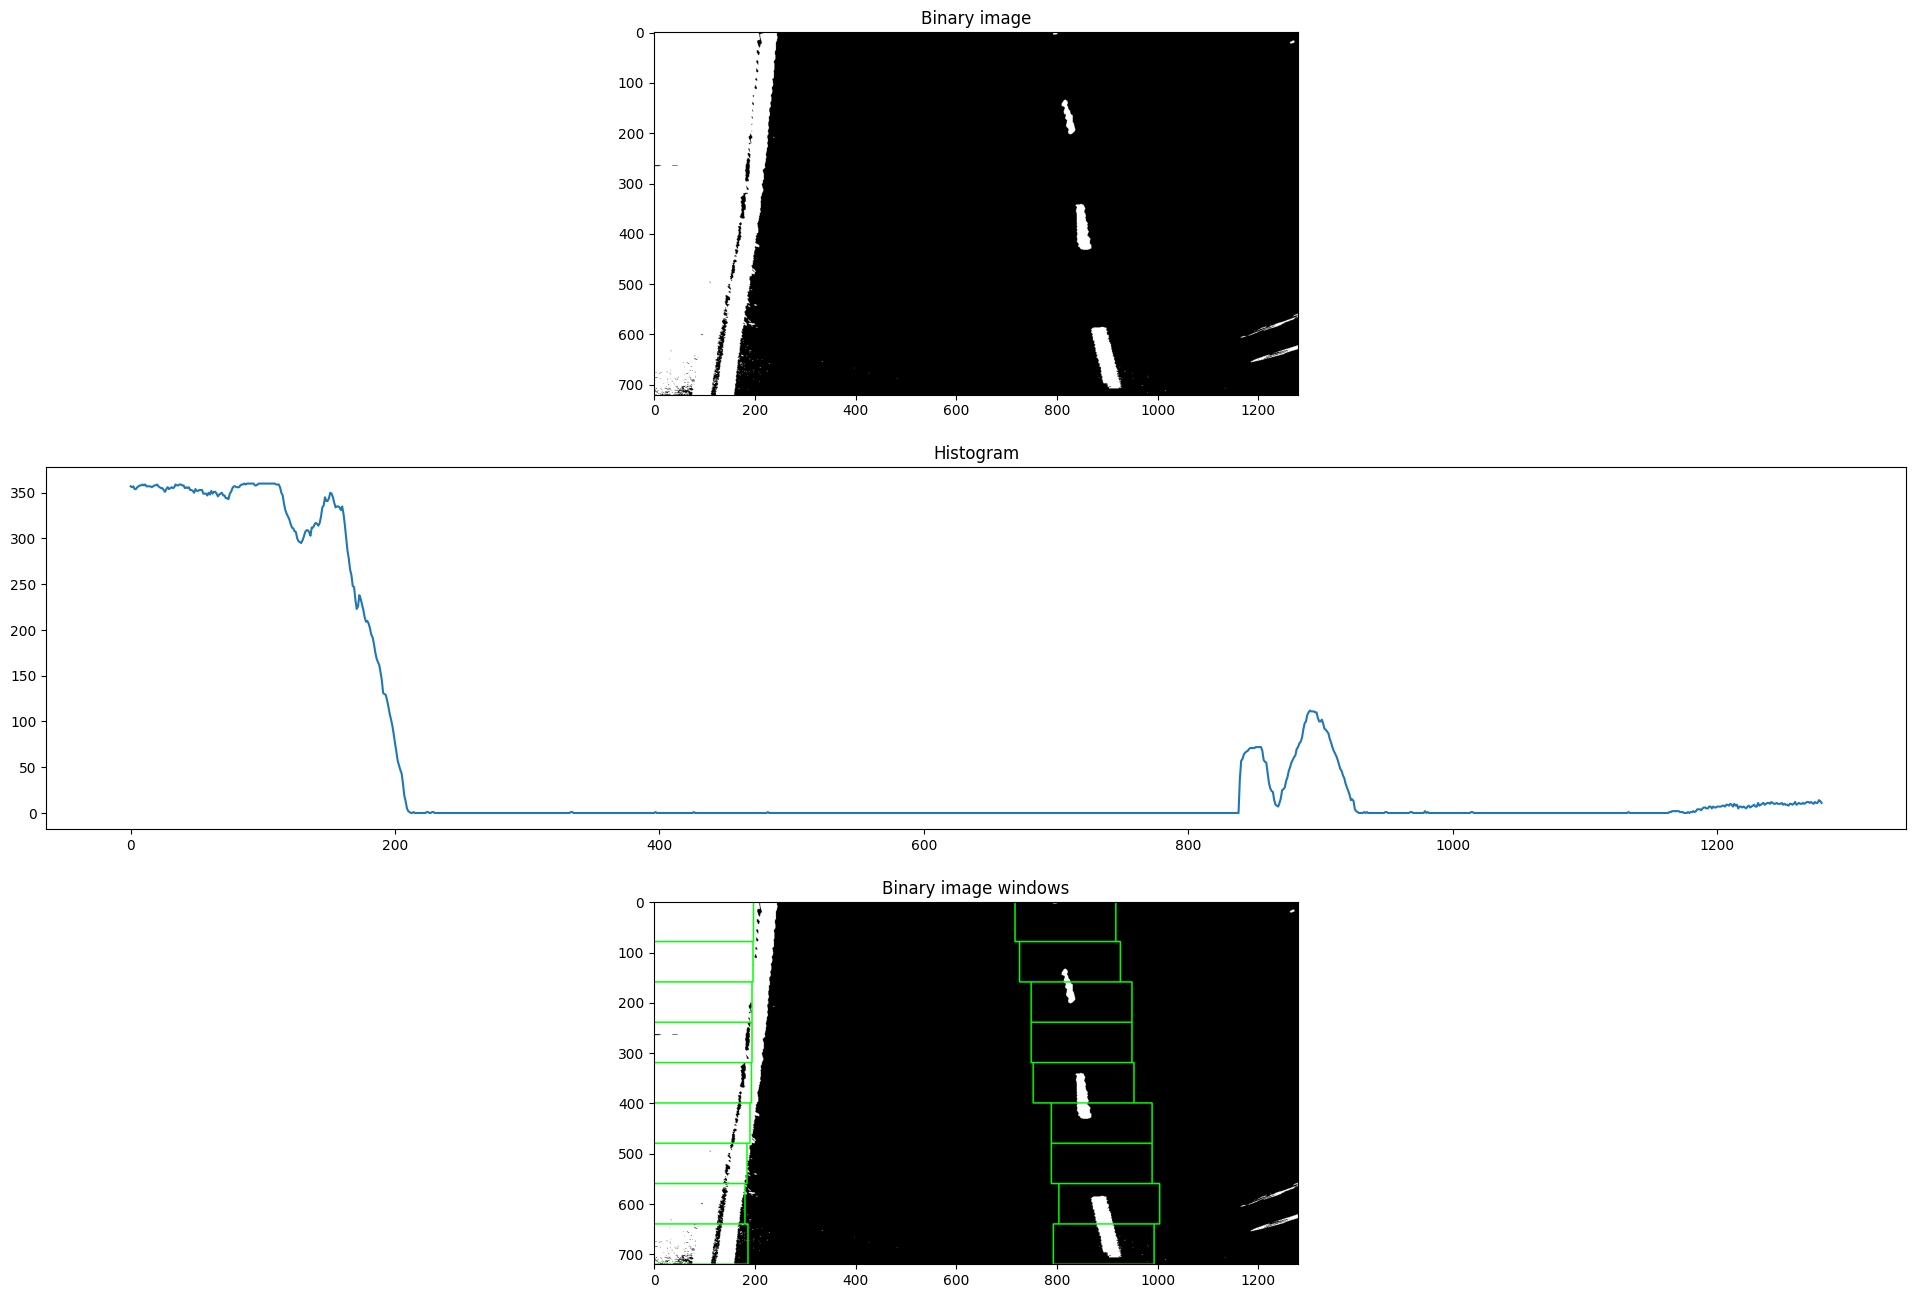

In [17]:
res_img_6 = find_lane_pixels(filtered_lane1, is_debug=True)

### 5.5 Fit Lane Polynom to Binary Image
This method is getting the matching right and left lane lines and returning the shape of the lane using polynomial fitting.
In our problem the y axis is kind of constant and we are looking for the matching x axis.
the function returns the calculated shape 

In [18]:
frame_counter['bad'] = 0

def fit_poly(bin_img):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(bin_img)

    if len(lefty) > 1500:
        # finds a 2nd degree polynom between y and a matching x (oppisite to the usual) 
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    maxy = bin_img.shape[0] - 1
    miny = bin_img.shape[0] // 3

    if len(lefty):
        maxy = max(maxy, np.max(lefty))
        miny = min(miny, np.min(lefty))

    if len(righty):
        maxy = max(maxy, np.max(righty))
        miny = min(miny, np.min(righty))

    ploty = np.linspace(miny, maxy, bin_img.shape[0])
    try:
        left_fitx  =  left_fit[0]*ploty**2 +  left_fit[1]*ploty +  left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)   
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))
        
        return out_img
    except Exception as e:
        global bad_frame_flag
        if bad_frame_flag:
            global frame_counter
            frame_counter['bad'] += 1
        
        points = np.array([[100, 150], [100, 700], [780, 700], [780, 100]],dtype=np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(out_img, [points], (255, 0, 0))
        return out_img

### 5.6 To Summerize Pipeline 
* Perspective Transform
* Apply Filter
* Do Polynomial Fitting
* Inverse Perspective Transform
* Combine Original Image with Lane Image

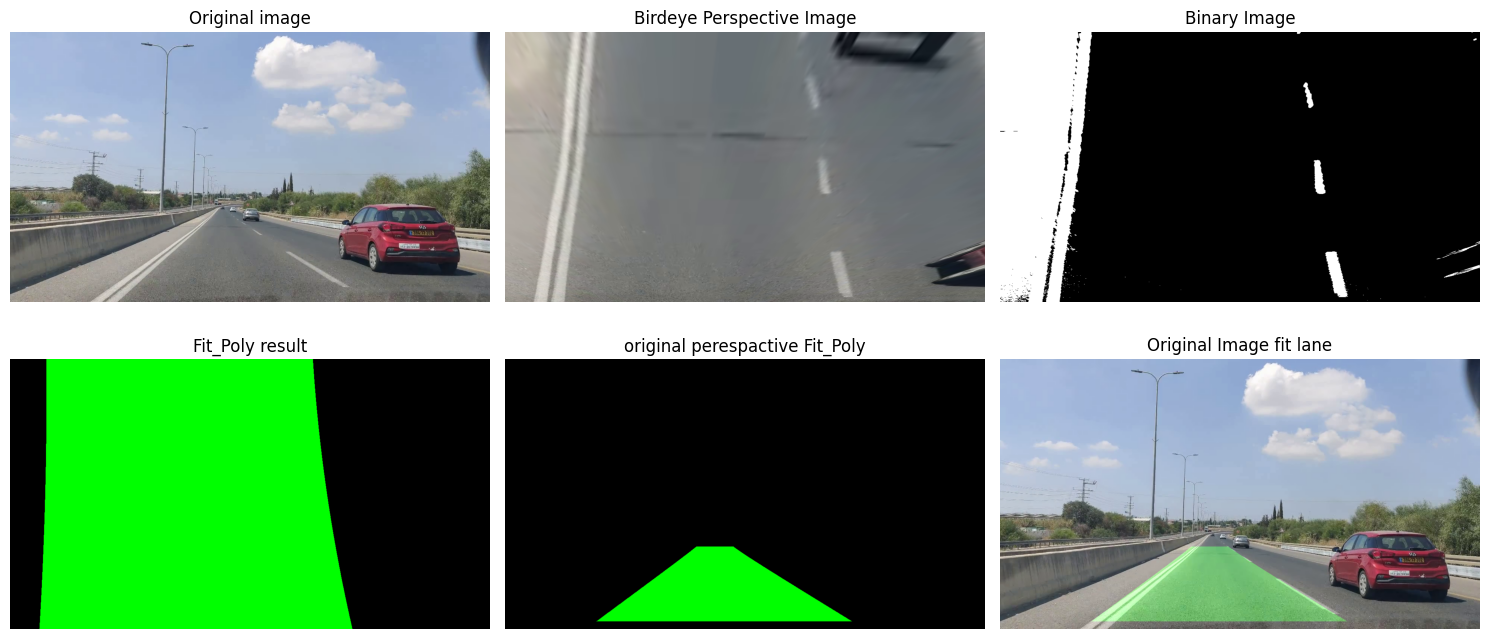

In [19]:
original_image = images[1]['img'].copy()
top_view2 = pers.forward(original_image)
filtered_lane1 =  filter_lanes(top_view2.copy(),is_rgb=True)
res_img4 = fit_poly(filtered_lane1)
img5 = pers.backward(res_img4)
out_img = ImgProc.weighted(original_image, img5, alpha=1, beta=0.3, gamma=0)

results_images = [
    {'img': original_image, 'title': 'Original image'},
    {'img': top_view2, 'title': 'Birdeye Perspective Image'},
    {'img': filtered_lane1, 'title': 'Binary Image','cmap': 'gray'},
    {'img': res_img4, 'title': 'Fit_Poly result', 'cmap': 'gray'},
    {'img': img5, 'title': 'original perespactive Fit_Poly', 'cmap': 'gray'},
    {'img': out_img, 'title': 'Original Image fit lane'},    
]

Utils.plot_images(*results_images,  width=5, height=3.5, n_cols=3, axis='off', save_fig="images/doc/a2/results_image_list.png")

### 5.7 Filter for Day
We chose to use the combined Heu and Light filter

In [20]:
# a shorter function - to make processing faster
def filter_day(img, l_c_low=0.65, l_c_h=0.72, v_c_l=0.69, is_rgb=False):
    """
    :param img: image in top view - bird eye view
    """
    if is_rgb:
        hls = ImgProc.convert_color(img, cv2.COLOR_RGB2HLS)
        hsv = ImgProc.convert_color(img, cv2.COLOR_RGB2HSV)
    else:
        #open cv uses BGR
        hls = ImgProc.convert_color(img, cv2.COLOR_BGR2HLS)
        hsv = ImgProc.convert_color(img, cv2.COLOR_BGR2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    v_channel = hsv[:,:,2]

    right_lane = ImgProc.threshold_rel(l_channel, l_c_low, l_c_h)
    right_lane[:,:750] = 0
    
    left_lane = ImgProc.threshold_abs(h_channel, 20, 40)
    left_lane &= ImgProc.threshold_rel(v_channel, v_c_l, 1.0)
    left_lane[:,550:] = 0

    binary_lane_mask = left_lane | right_lane
    
    return binary_lane_mask

### 5.8 Filter for night
I found that nomalizing the image and then doing relative thershold works the best for most cases, especially for night.

In [21]:
def filter_normalized(img, is_rgb=False,low_thresh=0.4):
    """
    :param img: image in top view - bird eye view
    """

    if is_rgb:
        gray = ImgProc.convert_color(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = ImgProc.convert_color(img, cv2.COLOR_BGR2GRAY)

    normalized = ImgProc.normalize(gray, alpha=170, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_thresh = ImgProc.threshold_rel(normalized, low_thresh, 1.0)
    
    # return  binary_lane_mask
    return normalized_thresh

## 6 Processing the Videos

### 6.1 Video Processor Implementation

In [22]:
class LaneTracker:
    def __init__(self, src_points, dst_points, is_rgb=True, normalize_filter=False) -> None:
        global frame_counter
        self.perspective_transformer =  PerspectiveTransformation(src_points, dst_points)
        self.is_rgb = is_rgb
        self.normalize_filter = normalize_filter
        self.normalized_low_thresh = 0.4
        for k in frame_counter:
            frame_counter[k] = 0
    
    def process_image(self, img):
        global frame_counter
        cur_bird_img = self.perspective_transformer.forward(img)
        if self.normalize_filter:
            binary_image =  filter_normalized(cur_bird_img, is_rgb=self.is_rgb, low_thresh=self.normalized_low_thresh)
        else:
            binary_image =  filter_day(cur_bird_img, is_rgb=self.is_rgb)
        res = fit_poly(binary_image)
        cur_img = self.perspective_transformer.backward(res)
        out_img = ImgProc.weighted(img, cur_img, alpha=1, beta=0.3, gamma=0)

        # increment frame counter
        frame_counter['all'] += 1
        return out_img

### 6.2 Daylight Video Processing

In [23]:
# define ROI
top_y = 550
bottom_y = 700
top_left, top_right = (450,top_y), (820,top_y)
bottom_left, bottom_right = (300,bottom_y), (1200,bottom_y)
src_points_1 = [top_left, bottom_left, bottom_right, top_right]

# process video
lane_tracker_day = LaneTracker(src_points_1, dst_points, normalize_filter=True)
vclip_day_processed_1 = day_vclip_1.fl_image(lambda img: lane_tracker_day.process_image(img))
# VidProc.display_video(vclip_day_processed_1)

#### Save processed video to file

In [24]:
out_file_names = {'daylight': "videos/out/a2/daylight_video_1280x720_out.mp4", 'night': "videos/out/a2/night_video_1280x720_out.mp4"}

In [25]:
VidProc.write_video(video_clip=vclip_day_processed_1, output_file=out_file_names['daylight'])

In [26]:
print(f"Bad frames ratio {frame_counter['bad']}/{frame_counter['all']} ({(frame_counter['bad']/frame_counter['all'])*100 if frame_counter['all'] > 0 else 0:.2f}%)")

Bad frames ratio 0/1 (0.00%)


#### Display processed video

In [27]:
VidProc.display_video(out_file_names['daylight'], title='Daylight Lane detection', method='html')

### 6.3 Night Video Processing

cahnged the filter

In [28]:
# video file location
input_video_night = 'videos/in/night_video_1280x720.mp4'

# read input video
vclip_night = VideoFileClip(input_video_night)

# define ROI
top_y = 585
bottom_y = 700
top_left, top_right = (500, top_y), (700, top_y)
bottom_left, bottom_right = (340,bottom_y), (920,bottom_y)
src_points_2 = [top_left, bottom_left, bottom_right, top_right]

# process video

lane_tracker_night = LaneTracker(src_points_2, dst_points, normalize_filter=True)
vclip_night_processed_1 = vclip_night.fl_image(lambda img: lane_tracker_night.process_image(img))

#### Save processed video to file

In [29]:
VidProc.write_video(video_clip=vclip_night_processed_1, output_file=out_file_names['night'])

In [30]:
print(f"Bad frames ratio {frame_counter['bad']}/{frame_counter['all']} ({(frame_counter['bad']/frame_counter['all'])*100 if frame_counter['all'] > 0 else 0:.2f}%)")

Bad frames ratio 0/1 (0.00%)


#### Display processed video

In [31]:
VidProc.display_video(out_file_names['night'], title='Night Lane detection', method='html')

## 7. Conclusion

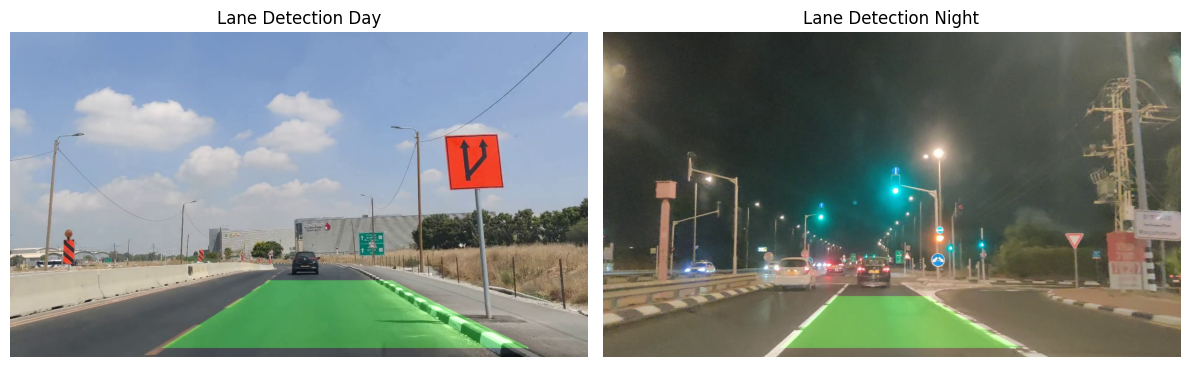

In [32]:
vcp1f = {'img': VidProc.get_clip_frame(vclip_day_processed_1, "115sec"), 'title': f'Lane Detection Day'}
vcp2f = {'img': VidProc.get_clip_frame(vclip_night_processed_1, "30sec"), 'title': f'Lane Detection Night'}
Utils.plot_images(vcp1f, vcp2f, width=6, height=4, axis='off', save_fig="images/doc/a2/lane_detection_conclusion.png")

Using this approach we able to detect the lane lines under certain conditions. However, we encounter challenges with very steep curves and when the car moves between lanes.


### Improvements
* Adapt lane detection to use only 1 side in a matching case 
* Make more adaptive window
    - for different curves
    - for different lanes
* Add context mechanism of the last few frames